In [12]:
from pyspark.sql.functions import split, col, current_timestamp

df = spark.read.parquet("/tmp/clickstream_data")

# Step 1: Filter out null messages
df_filtered = df.filter(df['message'].isNotNull())

# Step 2: Split 'message' into 'user' and 'page' assuming tab-separated values
df_split = df_filtered.withColumn("user", split(col("message"), "\t")[0]) \
                      .withColumn("page", split(col("message"), "\t")[1])

# Step 3: Drop original message column (optional)
df_selected = df_split.select("user", "page")

# Step 4: Add processing time
df_with_time = df_selected.withColumn("processing_time", current_timestamp())

# Step 5: Fill missing pages with 'unknown'
df_clean = df_with_time.na.fill({"page": "unknown"})

# Step 6: Group by user
df_agg = df_clean.groupBy("user").count()

# Show results
df_agg.show()

# Optional: Save
df_agg.write.mode("overwrite").parquet("/tmp/clickstream_processed")



+--------------------+-----+
|                user|count|
+--------------------+-----+
|          Lashkargah|    1|
|List_of_D.Gray-ma...|    1|
| Rhineland_massacres|    1|
|Anti-Jewish_pogro...|    1|
|      Annet_Mahendru|    1|
|  The_Sun_Also_Rises|    1|
|The_Passion_of_th...|    1|
|Das_Judenthum_in_...|    1|
|List_of_countries...|    1|
|    Figure_of_speech|    1|
|List_of_narrative...|    1|
|  Harvard_University|    1|
|       Dina_Eastwood|    1|
|List_of_nursing_s...|    1|
|Contemporary_witc...|    1|
|Little_Saint_Hugh...|    1|
|     Six_(TV_series)|    1|
|   Chandler,_Arizona|    1|
|  List_of_occultists|    2|
|Manas_Internation...|    1|
+--------------------+-----+
only showing top 20 rows


In [13]:
# Show schema
df_clean.printSchema()

# Count nulls in each column
from pyspark.sql.functions import col, sum as _sum

null_counts = df_clean.select([_sum(col(c).isNull().cast("int")).alias(c) for c in df_clean.columns])
null_counts.show()


root
 |-- user: string (nullable = true)
 |-- page: string (nullable = false)
 |-- processing_time: timestamp (nullable = false)

+----+----+---------------+
|user|page|processing_time|
+----+----+---------------+
|   0|   0|              0|
+----+----+---------------+



In [ ]:
# Drop rows where any column is null
df_no_nulls = df_clean.dropna()

# OR: Fill nulls for specific columns
df_filled = df_clean.fillna({"page": "unknown", "user": "anonymous"})

df_filled.show()



+--------------------+-----------+--------------------+
|                user|       page|     processing_time|
+--------------------+-----------+--------------------+
|List_of_sovereign...|Afghanistan|2025-05-27 11:50:...|
|      Annet_Mahendru|Afghanistan|2025-05-27 11:50:...|
|        Afghan_bread|Afghanistan|2025-05-27 11:50:...|
|List_of_countries...|Afghanistan|2025-05-27 11:50:...|
|           Main_Page|Afghanistan|2025-05-27 11:50:...|
|List_of_Asian_cou...|Afghanistan|2025-05-27 11:50:...|
|   Geography_of_Asia|Afghanistan|2025-05-27 11:50:...|
|Islamic_Military_...|Afghanistan|2025-05-27 11:50:...|
|Presidency_of_Bar...|Afghanistan|2025-05-27 11:50:...|
|List_of_minimum_w...|Afghanistan|2025-05-27 11:50:...|
|     Six_(TV_series)|Afghanistan|2025-05-27 11:50:...|
| List_of_Asian_films|Afghanistan|2025-05-27 11:50:...|
|Golden_Triangle_(...|Afghanistan|2025-05-27 11:50:...|
| Battle_of_Saragarhi|Afghanistan|2025-05-27 11:50:...|
|     Zablon_Simintov|Afghanistan|2025-05-27 11:

In [6]:
# Count unique users and pages
df_filled.select("user").distinct().count()
df_filled.select("page").distinct().count()

# Get most visited pages
df_filled.groupBy("page").count().orderBy("count", ascending=False).show(10)


+--------------------+-----+
|                page|count|
+--------------------+-----+
|              Arabic|  854|
|         Afghanistan|  714|
|        Antisemitism|  357|
|         Agriculture|  308|
|              Apollo|  296|
|    Aleister_Crowley|  263|
|American_Film_Ins...|  242|
|                ABBA|  189|
|                Atom|  179|
|  Anarcho-capitalism|  121|
+--------------------+-----+
only showing top 10 rows


In [8]:
# Convert to Pandas DataFrame
pandas_df = df_filled.select("user", "page").toPandas()


/tmp/ipykernel_30115/177789096.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=page_counts.values, y=page_counts.index, palette="viridis")


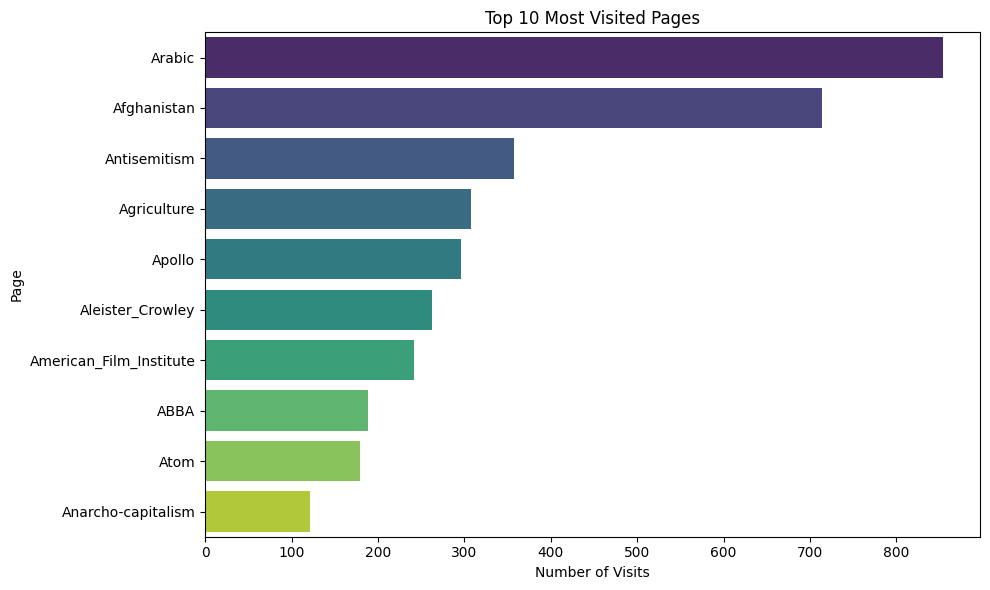

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count page visits
page_counts = pandas_df['page'].value_counts().head(10)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=page_counts.values, y=page_counts.index, palette="viridis")
plt.title("Top 10 Most Visited Pages")
plt.xlabel("Number of Visits")
plt.ylabel("Page")
plt.tight_layout()
plt.show()


/tmp/ipykernel_30115/880181006.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=user_counts.values, y=user_counts.index, palette="magma")


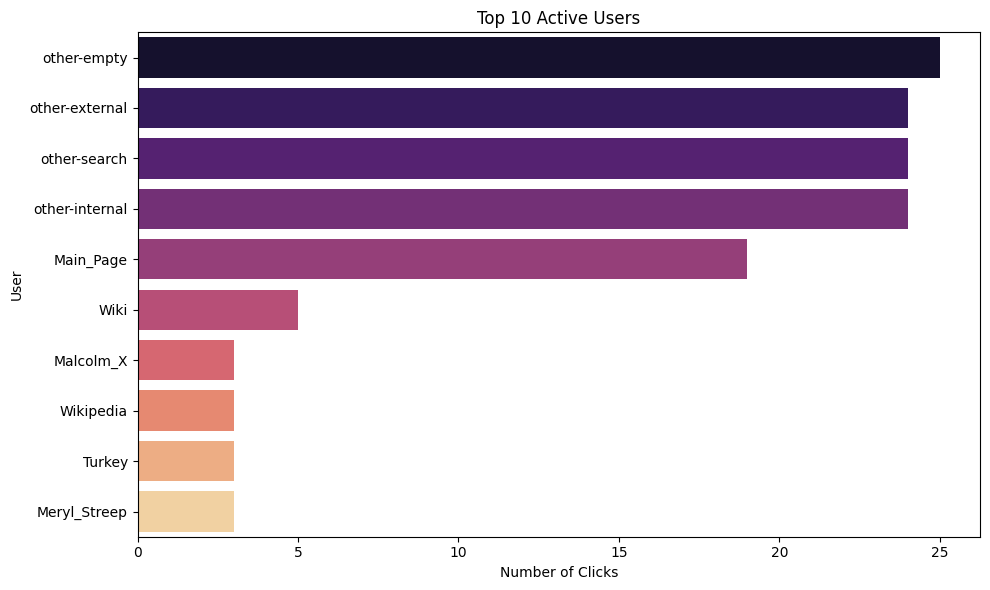

In [11]:
user_counts = pandas_df['user'].value_counts().head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x=user_counts.values, y=user_counts.index, palette="magma")
plt.title("Top 10 Active Users")
plt.xlabel("Number of Clicks")
plt.ylabel("User")
plt.tight_layout()
plt.show()
